In [1]:
import numpy as np
import pandas as pd
# %matplotlib notebook
import pickle
import os
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from collections import Counter
from sklearn import metrics
from datetime import datetime
from utils.utils import *
from joblib import Parallel, delayed
from copy import deepcopy
import math




def f1Bias_scorer_CV(probs, y, ret_bias=True):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)
    f1,bias = 0.0,.5
    min_recall = .7
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and recall[i]>min_recall:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]
    if ret_bias:
        return f1, bias
    return f1


def cluster_specific_result_collection(result_phenotypes):
    for key in result_phenotypes.keys():
        average_int = float(result_phenotypes[key][1])/result_phenotypes[key][0]
        captured_lapse = float(result_phenotypes[key][2])/result_phenotypes[key][3]
        mean_gap = np.mean(result_phenotypes[key][4])
        result_phenotypes[key][5].append(average_int)
        result_phenotypes[key][6].append(captured_lapse)
        result_phenotypes[key][7].append(mean_gap)
    return result_phenotypes

def smooth_y_pred(y_time_pid,y_pred_pid):
    df = pd.DataFrame({'time':y_time_pid,'prob':y_pred_pid}).sort_values('time').reset_index(drop=True)
    y_pred_pid = df['prob'].rolling(window=10).mean().fillna(0).values
    return y_pred_pid

def get_lapse_times(puff_data,par):
    return sorted(np.array([np.datetime64(datetime.fromtimestamp(lapse_time/1000)) for lapse_time in puff_data[puff_data['Participant']==int(par)]['Lapse'].values]))[:1]
            

def get_int_times_count(y_time_pid,y_pred_pid,timescap,bias):
    ipd = 0
    int_times = []
    prev_time = np.min(y_time_pid)
    for p,ys in enumerate(y_pred_pid):
        timedelta = y_time_pid[p] - prev_time
        mins = timedelta.astype('timedelta64[m]').astype(np.int32)
        if mins>=timescap and ys>bias:
            ipd+=1
            int_times.append(y_time_pid[p])
            prev_time = y_time_pid[p]
    return np.array(int_times), ipd


def ascertain_lapse(lapse_times, 
                    int_times, 
                    lapse_captured, 
                    cluster_dict, 
                    par, 
                    gap_s, 
                    result_phenotypes,
                    phenotype_specific = True
                    ):
    
    for lapse_time in lapse_times:
        int_times_lapse = sorted(np.array([a for a in int_times if a<lapse_time]))
        if len(int_times_lapse)==0:
            continue
        gap_lapse_ = lapse_time- np.max(int_times_lapse)
        gap_lapse_ = gap_lapse_.astype('timedelta64[m]').astype(np.int32)
        if abs(gap_lapse_)<gap_th:
            lapse_captured+=1
            if phenotype_specific:
                result_phenotypes[cluster_dict[par]][2]+=1
        if gap_lapse_<500:
            gap_s.append(abs(gap_lapse_))
            if phenotype_specific:
                result_phenotypes[cluster_dict[par]][4].append(abs(gap_lapse_))
    return result_phenotypes, gap_s, lapse_captured

def get_final_step(final_intpday,final_recall,final_gap,result_phenotypes,iteration,x,all_data,name='Overall',phenotype_specific=True):
    result_final = get_smoothed_result(final_intpday,final_recall,final_gap)
    result_final = get_interpolated_data(result_final,x,name=name,iteration=iteration)
    all_data.extend(result_final)
    if phenotype_specific:
        for key in result_phenotypes.keys():
            result_this_cluster = get_smoothed_result(result_phenotypes[key][5],
                                                            result_phenotypes[key][6],
                                                            result_phenotypes[key][7])
            result_final_cluster = get_interpolated_data(result_this_cluster,x,name='Cluster {}'.format(key),iteration=iteration)
            all_data.extend(result_final_cluster)
    return all_data

def get_results(iteration):
    all_data = []
    final_intpday,final_recall,final_gap = [],[],[]
    pred_index = indexes_pred
    result_phenotypes = deepcopy(result_phenotypes_final)
    if episode_presence==0:
        min_,max_ = .2,.54
    elif episode_presence==2:
        min_,max_ = .23,.53
    else:
        min_,max_ = .26,.51
    for bias in np.arange(.05,.8,.01):
        timescap = 60
        part_days, total_ipd, lapse_captured, total_lapsers,gap_s = 0,0,0,0,[]
        for key in result_phenotypes.keys():
            for ii in range(4):
                result_phenotypes[key][ii] = 0
            result_phenotypes[key][4] = []
        for i,par in enumerate(pars):
            a = np.where(y_pid==par)[0]
            lapse_times = get_lapse_times(puff_data,par)
            total_lapsers+=len(lapse_times)
            result_phenotypes[cluster_dict[par]][3]+=len(lapse_times)
            
            y_pred_pid = y_pred[a][:,pred_index]
            biases = np.array(bias_dict[par])[pred_index]
            for ii in range(y_pred_pid.shape[1]):
                y_pred_pid[:,ii] = np.array(y_pred_pid[:,ii]>=np.percentile(y_pred_pid[:,ii],percentile),dtype=int)
            y_pred_pid = np.mean(y_pred_pid,axis=1)
            
            y_test_pid,y_time_pid = y_test[a],y_time[a]
            y_time_pid = np.array([y+np.timedelta64(time_gap_delta, 'm') for y in y_time_pid])
            y_pred_pid = y_pred_pid[y_time_pid.argsort()]
            y_test_pid = y_test_pid[y_time_pid.argsort()]
            y_time_pid = np.array(sorted(y_time_pid))
            y_day_pid = np.array([str(a)[:10] for a in y_time_pid])
            if smoothing:
                y_pred_pid = smooth_y_pred(y_time_pid,y_pred_pid)
            part_days+=len(np.unique(y_day_pid))
            result_phenotypes[cluster_dict[par]][0]+=len(np.unique(y_day_pid))
            
            int_times, ipd =  get_int_times_count(y_time_pid,y_pred_pid,timescap,bias)    
            total_ipd+=ipd
            result_phenotypes[cluster_dict[par]][1]+=ipd
            
            if len(int_times)>0:
                result_phenotypes, gap_s, lapse_captured = ascertain_lapse(lapse_times, 
                                                                            int_times, 
                                                                            lapse_captured, 
                                                                            cluster_dict, 
                                                                            par, 
                                                                            gap_s, 
                                                                            result_phenotypes)
            
        final_day_th = float(total_ipd)/part_days
        final_intpday.append(final_day_th)
        final_gap.append(np.median(gap_s))
        final_recall.append(float(lapse_captured)/total_lapsers)
        result_phenotypes = cluster_specific_result_collection(result_phenotypes=result_phenotypes)
        
    all_data = get_final_step(final_intpday,final_recall,final_gap,result_phenotypes,iteration,x,all_data,name='Overall')
    return all_data

def get_df(df):
    if df.shape[0]==0:
        return df
    df = df.sort_values('time').reset_index(drop=True)
    timescap = df['timescap'].values[0]//2
    indexes = np.arange(timescap)
    index = np.random.choice(indexes,1)[0]
    if index>df.shape[0]-1:
        return df
    df['pred'].at[index] = 1
    return df




def get_baseline_result(iteration):
    all_data = []
    final_intpday = []
    final_recall = []
    final_gap = []
    result_phenotypes = deepcopy(result_phenotypes_final)
    for timescap in list(np.arange(10,240,10)):
        part_days = 0
        total_ipd = 0
        lapse_captured = 0
        gap_s = []
        total_lapsers = 0
        for key in result_phenotypes.keys():
            result_phenotypes[key][0] = 0
            result_phenotypes[key][1] = 0
            result_phenotypes[key][2] = 0
            result_phenotypes[key][3] = 0
            result_phenotypes[key][4] = []
        
        for i,par in enumerate(pars):
            a = np.where(y_pid==par)
            if len(a[0])==0:
                continue
            lapse_times = get_lapse_times(puff_data,par)
            total_lapsers+=len(lapse_times)
            result_phenotypes[cluster_dict[par]][3]+=len(lapse_times)
            
            y_time_pid = y_time[a]
            y_time_pid = np.array([y+np.timedelta64(time_gap_delta, 'm') for y in y_time_pid])
            y_time_pid = np.array(sorted(y_time_pid))
            y_day_pid = np.array([str(a)[:10] for a in y_time_pid])
            total_minutes = 0
            for day in np.unique(y_day_pid):
                y_time_pid1 = sorted(y_time_pid[y_day_pid==day])
                total_minutes+= (y_time_pid1[-1]-y_time_pid1[0]).astype('timedelta64[m]').astype(np.int32)
            ipd = math.ceil(total_minutes/timescap)
            udays = len(np.unique(y_day_pid))
            part_days+=udays
            result_phenotypes[cluster_dict[par]][0]+=udays
            
            df_pid = pd.DataFrame({'time':y_time_pid,
                                    'pred':[0]*len(y_time_pid)})
            df_pid['timescap'] = timescap
            df_all = df_pid.groupby(pd.Grouper(key='time',freq=str(60*timescap)+'S')).apply(get_df)
            int_times = df_all[df_all.pred==1]['time'].values
            
            if len(int_times)>0:
                result_phenotypes, gap_s, lapse_captured = ascertain_lapse(lapse_times, 
                                                                            int_times, 
                                                                            lapse_captured, 
                                                                            cluster_dict, 
                                                                            par, 
                                                                            gap_s, 
                                                                            result_phenotypes)
            
            total_ipd+=ipd
            result_phenotypes[cluster_dict[par]][1]+=ipd
            
        final_day_th = float(total_ipd)/part_days
        final_intpday.append(final_day_th)
        final_gap.append(np.mean(gap_s))
        final_recall.append(float(lapse_captured)/total_lapsers)
        result_phenotypes = cluster_specific_result_collection(result_phenotypes=result_phenotypes)
    all_data = get_final_step(final_intpday,final_recall,final_gap,result_phenotypes,iteration,x,all_data,name='Overall')
    return all_data

def return_important_vars(episode_presence,n_lag=15,n_cluster = 2,obs = 30):
    data_file = './data/episode_encoded_lagged_data_with_episode/episode_encoded_'+'lagged_'+str(n_lag)+'_obs_{}'.format(obs)+'_windows_with_episode_cluster_check_{}'.format(n_cluster)
    if episode_presence==0:
        # episode_label = 'only'
        # filename = './data/output_final_all/result_'+str(episode_label)+'_episode_lag_{}_obs_{}_triplet_loss_cluster___pos_to_neg_none_v111{}{}.p'.format(n_lag,obs,n_cluster,.2)        
        filename = './data/output_final_all/result_only_episode_lag_{}_obs_{}_triplet_loss_cluster_{}_revised_loss_alpha_{}_softmax_{}_loss_{}_rare_{}_positive_{}_percentile_{}.p'.format(n_lag,obs,n_cluster,.2,50,10,1,.2,80)
        filename = './data/output_final_all/result_only_episode_lag_15_obs_30_triplet_loss_cluster_4_revised_loss_alpha_0.3_softmax_10_loss_50_rare_1_positive_0.2_percentile_80.p'
        # filename = './data/output_final_all/distance_lag_15_obs_30_triplet_loss_cluster_4_revised_loss_alpha_0.351_softmax_10_loss_50_rare_1_positive_0.2_percentile_80.p'
    elif episode_presence==1:
        filename = './data/output_final_all/distance_lag_15_obs_30_triplet_loss_cluster_4_triplet_loss_alpha_0.2_softmax_1_loss_1_rare_1_positive_0.2_percentile_80.p'
    elif episode_presence==3:
        filename = './data/output_final_all/no_episode_distance_lag_15_obs_30_triplet_loss_cluster_4_triplet_loss_alpha_0.3_softmax_1_loss_1_rare_1_positive_0.2_percentile_80.p' 
        
    else:
        # episode_label = 'no'
        filename = './data/output_final_all/result_no_episode_lag_{}_obs_{}_triplet_loss_cluster_{}_revised_loss_alpha_{}_softmax_{}_loss_{}_rare_{}_positive_{}_percentile_{}.p'.format(n_lag,obs,n_cluster,.2,10,50,1,.2,80)      
        filename = './data/output_final_all/result_no_episode_lag_15_obs_30_triplet_loss_cluster_4_revised_loss_alpha_0.3_softmax_10_loss_50_rare_1_positive_0.2_percentile_80.p'  
        # filename = './data/output_final_all/no_episode_distance_lag_15_obs_30_triplet_loss_cluster_4_revised_loss_alpha_0.35_softmax_10_loss_50_rare_1_positive_0.2_percentile_80.p'    
    data_eval = pickle.load(open(filename,'rb'))
    file1 = './data/mRisk/mRisk_Lapse_postquit.csv'
    puff_data = pd.read_csv(file1)
    data_feature_label = pickle.load(open(data_file,'rb'))
    data_cluster = pickle.load(open(data_file,'rb'))
    temp = data_cluster.groupby(['user','cluster_label']).count().index.values
    users = np.array([a[0] for a in temp])
    labels = np.array([a[1] for a in temp])
    cluster_dict = {}
    for i,a in enumerate(users):
        cluster_dict[a] = labels[i]
    y_time,y_pred,y_test,y_pid,bias_dict,val_results = data_eval[0],np.array(data_eval[1]),data_eval[2],data_eval[3],data_eval[4],data_eval[5]
    y_time,y_pred,y_test,y_pid,pars = np.array(y_time),np.array(y_pred).reshape(len(y_test),-1),np.array(y_test),np.array(y_pid),np.unique(y_pid)
    lapse_captured_dict = {}
    total_lapsers = 0
    result_phenotypes_final = {}
    for label in np.unique(list(cluster_dict.values())):
        result_phenotypes_final[label] = [0,0,0,0,[],[],[],[]]
    return y_pred, y_test, y_time, y_pid, lapse_captured_dict, result_phenotypes_final, cluster_dict, puff_data, data_feature_label, total_lapsers, pars, bias_dict
    


smoothing = False            
n_cluster = 4          
time_gap_delta = 20
gap_th = 60
# inc = ['3002', '3004', '3005', '3006', '3007', '3009', '3013', '3014', '3015', '3022', '3024', '3025', '3029', '3031', '3033',
#  '3036', '3038', '3041', '3045', '3048', '3050', '3053', '3076', '3077', '3079', '3086', '3088', '3091', '3095', '3099',
#  '3101', '3102', '3122', '3125', '3126', '3128', '3133', '3135', '3137', '3138', '3139', '3143', '3145', '3148', '3152',
#  '3153', '3158', '3160', '3164', '3165', '3166', '3168']
n_lag = 15
n_iters = 1
n_sample = 5
x = np.array(list(np.arange(2,8.5,.5)))
df_all = []
done_ = False
data_dict = {}
for episode_presence in [0,2]:
    y_pred, y_test, y_time, y_pid, lapse_captured_dict, result_phenotypes_final, cluster_dict, puff_data, data_feature_label, total_lapsers, pars, bias_dict = return_important_vars(episode_presence=episode_presence,n_lag=n_lag,n_cluster=n_cluster)
    indexes_pred = np.arange(y_pred.shape[1])
    for percentile in [80]:
        for bias in [.4]:
            if episode_presence in [0,1,2,3]:
                n_iters = 1
                # if episode_presence==0:
                #     bias = .4
                # else:
                #     bias = .4
                print(bias,percentile)
                all_data_v1 = [get_results(iteration) for iteration in np.arange(n_iters)]
                # all_data_v1 = [get_results(iteration) for iteration in np.arange(n_iters)]
            if episode_presence ==4 and not done_:
                done_ = True
                n_iters = 2
                all_data_v1 = Parallel(n_jobs=-1,verbose=2)(delayed(get_baseline_result)(iteration) for iteration in np.arange(n_iters))
                # all_data_v1 = [get_baseline_result(iteration) for iteration in np.arange(n_iters)]
            all_data = []
            for a in all_data_v1:
                all_data.extend(a)
            df2 = pd.DataFrame(all_data,columns=['Interventions per day','IHR','TPI','Subtype','Iteration'])
            if episode_presence==0:
                df2['Encoding'] = ['DDHI']*df2.shape[0]
                data_dict['DDHI'] = [y_pred, y_test, y_time, y_pid]
                # df2['Encoding'] = ['Proposed Event Stream Encoding plus Continuous Features']*df2.shape[0]
            elif episode_presence==1:
                df2['Encoding'] = ['DDHI - Triplet loss']*df2.shape[0]
                # df2['Encoding'] = ['Continuous & Event Stream Computed Features']*df2.shape[0]
            elif episode_presence==2:
                df2['Encoding'] = ['DRES']*df2.shape[0]
                data_dict['DRES'] = [y_pred, y_test, y_time, y_pid]
            elif episode_presence==3:
                df2['Encoding'] = ['DRES - Triplet loss']*df2.shape[0]
                # df2['Encoding'] = ['Proposed Event Stream Encoding Only']*df2.shape[0]
            elif episode_presence==4:
                df2['Encoding'] = ['Random Baseline']*df2.shape[0]
            df2['Encoding1'] = episode_presence
            df2['Bias'] = bias
            df2['percentile'] = percentile
            df_all.append(df2)
df=pd.concat(df_all)
df1 = df.copy()

0.4 80
0.4 80


In [2]:
# len(np.unique(y_pid))

58

In [6]:
puff_data

,Participant,EMA_support,hours,Quit Day,Lapse
0,3002,1,0.0,1.497017e+12,1497051829783
1,3004,1,71.0,1.498230e+12,1498516098469
2,3005,1,0.0,1.498658e+12,1498681506198
3,3006,1,16.0,1.498591e+12,1498650291327
4,3006,1,19.0,1.498591e+12,1498660795431
...,...,...,...,...,...
117,3164,1,0.0,1.552685e+12,1552920960924
118,3165,1,0.0,1.553016e+12,1553211207837
119,3166,1,0.0,1.553268e+12,1553459532213
120,3168,1,0.0,1.553534e+12,1553556987566


In [2]:
# import seaborn as sns
# df_final = df[df.Subtype.isin(['Overall'])]
# for bias in df_final.Bias.unique():
#     for percentile in df_final.percentile.unique():
#         df_this = df_final[(df_final.Bias==bias) & (df_final.percentile==percentile)]
#         print(bias,percentile)
#         plt.figure(figsize=(10,8))
#         sns.barplot(x='Interventions per day',y='IHR',hue='Encoding',data=df_this)
#         plt.grid()
#         plt.show()
# df_final['Interventions per day']+=1
df_final = df1
df_result = df_final[df_final.Subtype.isin(['Overall'])]
tpi_table1 = pd.pivot_table(df_result,columns='Interventions per day',values='IHR',index='Encoding',aggfunc='mean')
# tpi_table1.to_csv('ihr.csv')
tpi_table = pd.pivot_table(df_result,columns='Interventions per day',values='TPI',index='Encoding',aggfunc='mean')
# tpi_table.to_csv('tpi.csv')
tpi_table1

Interventions per day,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0
Encoding,,,,,,,,,,,,,
DDHI,0.333333,0.445582,0.518286,0.592134,0.682341,0.714886,0.755939,0.814176,0.829154,0.920093,0.913793,0.913793,0.913793
DRES,0.413793,0.382081,0.458383,0.549507,0.636116,0.736507,0.760436,0.782950,0.842529,0.930773,0.931034,0.931034,0.931034


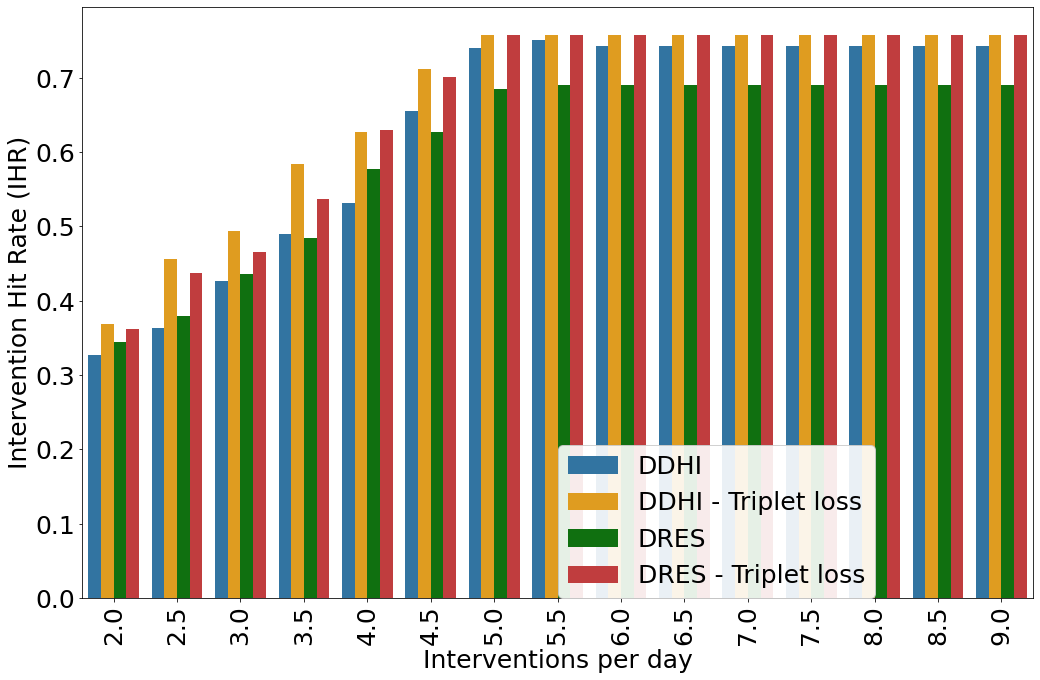

In [2]:

df_final = df1
perf = 'IHR'
# df_final
import seaborn as sns
import seaborn as sns
colors = ['tab:blue',"orange", "green",'tab:red']
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

# df_final = df
# df_final = df_final[df_final['Interventions per day'].isin(np.arange(3,10))]
plt.rcParams.update({'font.size':25})
fig,ax = plt.subplots(1,1,figsize=(15,10),sharey=True)
ax = [ax]
sns.barplot(x='Interventions per day',y=perf,hue='Encoding',data=df_final[df_final.Subtype.isin(['Overall'])],ci=None,ax=ax[0])
plt.legend([],[])
# ax[0].grid()
# ax[0].set_ylabel('Intervention Hit Rate(IHR)',color='r')
# ax[0].legend([],[], frameon=False)
ax[0].tick_params(axis='y', colors='k')
ax[0].tick_params(axis='x', rotation=90)
# ax[0].set_ylim([0,.99])
# ax1=ax.twinx()
# sns.barplot(y='Interventions per day',x='TPI',orient='h',hue='Encoding',data=df_final[df_final.Subtype.isin(['Overall'])],ci=None,ax=ax[1])
if perf=='IHR':
    ax[0].set_ylabel('Intervention Hit Rate (IHR)',color='k')
    # ax[0].set_ylim([0,.99])
else:
    ax[0].set_ylabel('Temporal Precision of Interventions (TPI),\n minutes',color='g')
# ax[1].tick_params(axis='y', colors='g')
# plt.xticks(rotation=90)
# # ax[1].grid()
# ax[1].legend(loc=(-1.3,1.01),ncol=2)
# # plt.tight_layout()
# # plt.savefig('./data/images/deep_model.png')
# # plt.tight_layout()
# ax[0].grid()
plt.legend(loc=(.5,0), numpoints=1, ncol=1,frameon=True,fancybox=True,framealpha=.9)
# plt.title('Model Performance -'+str(perf))
# ax[1].grid()
plt.tight_layout()
plt.savefig('./data/images/'+str(perf)+'.png')
plt.show()

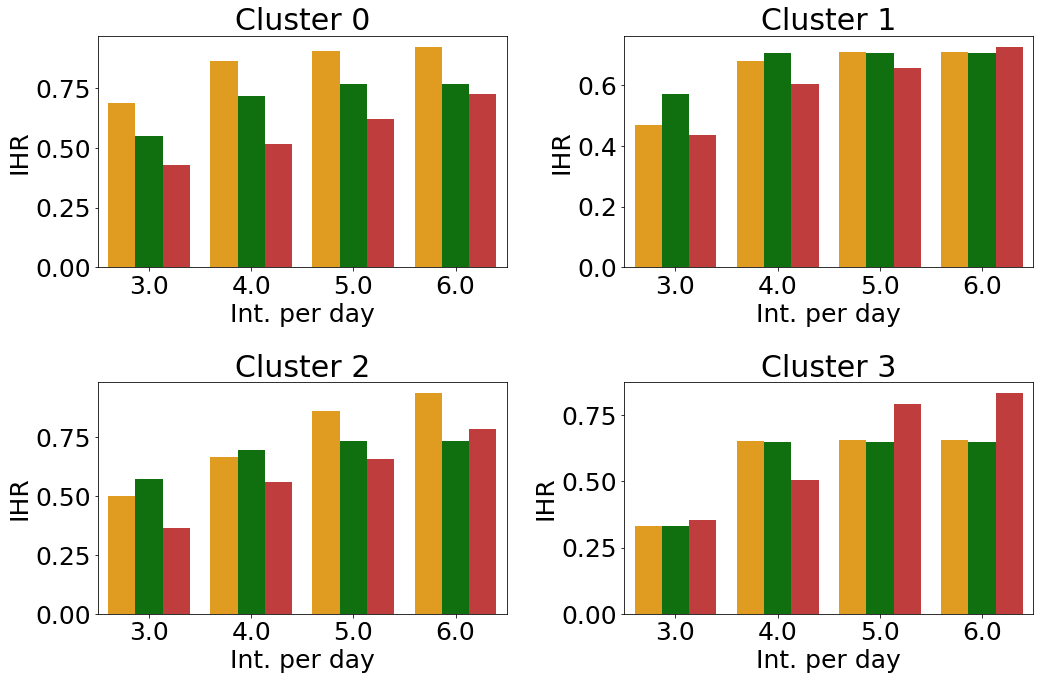

In [23]:
import seaborn as sns
colors = ["orange", "green",'tab:red']
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
# And then, from here onwards, it's exactly
plt.rcParams.update({'font.size':25})
df2 = df1[df1['Interventions per day'].isin(np.arange(3,8))]
n_clusters = np.unique(list(cluster_dict.values())).shape[0]
fig,ax = plt.subplots(2,n_clusters-2,figsize=(15,10),sharey=False)
ax = np.array(ax).reshape(-1)
for i in range(len(ax)):
    sns.barplot(x='Interventions per day',y='IHR',hue='Encoding',data=df2[df2.Subtype.isin(['Cluster {}'.format(i)])],ci=None,ax=ax[i])
    # if i!=0:
    ax[i].legend([],[], frameon=False)
    # else:
    #     ax[i].legend(ncol=1,loc=(-.9,.3),frameon=False)
    ax[i].set_xlabel('Int. per day')
    ax[i].set_title('Cluster {}'.format(i))
    # ax[i].set_xticks([0,1,2,3])
    # ax[i].set_xticklabels([3,4,5,6])
    
    # ax[i].set_ylim([-1,8])
# plt.legend(ncol=3)
# plt.xlabel('Interventions per day')
plt.tight_layout()
plt.savefig('./data/images/cluster_wise_perf.png')
plt.show()

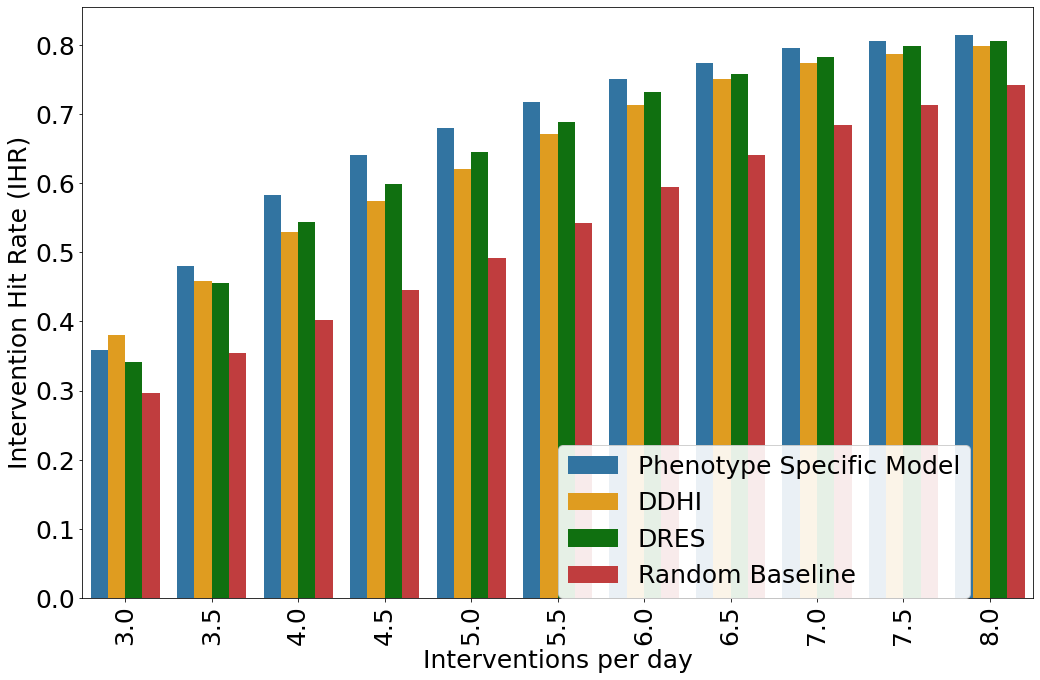

In [22]:

df_final = df1

perf = 'IHR'
# df_final
import seaborn as sns
import seaborn as sns
colors = ['tab:blue',"orange", "green",'tab:red']
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

# df_final = df
# df_final = df_final[df_final['Interventions per day'].isin(np.arange(3,10))]
plt.rcParams.update({'font.size':25})
fig,ax = plt.subplots(1,1,figsize=(15,10),sharey=True)
ax = [ax]
sns.barplot(x='Interventions per day',y=perf,hue='Encoding',data=df_final[df_final.Subtype.isin(['Overall'])],ci=None,ax=ax[0])
plt.legend([],[])
# ax[0].grid()
# ax[0].set_ylabel('Intervention Hit Rate(IHR)',color='r')
# ax[0].legend([],[], frameon=False)
ax[0].tick_params(axis='y', colors='k')
ax[0].tick_params(axis='x', rotation=90)
# ax[0].set_ylim([0,.99])
# ax1=ax.twinx()
# sns.barplot(y='Interventions per day',x='TPI',orient='h',hue='Encoding',data=df_final[df_final.Subtype.isin(['Overall'])],ci=None,ax=ax[1])
if perf=='IHR':
    ax[0].set_ylabel('Intervention Hit Rate (IHR)',color='k')
    # ax[0].set_ylim([0,.99])
else:
    ax[0].set_ylabel('Temporal Precision of Interventions (TPI),\n minutes',color='g')
# ax[1].tick_params(axis='y', colors='g')
# plt.xticks(rotation=90)
# # ax[1].grid()
# ax[1].legend(loc=(-1.3,1.01),ncol=2)
# # plt.tight_layout()
# # plt.savefig('./data/images/deep_model.png')
# # plt.tight_layout()
# ax[0].grid()
plt.legend(loc=(.5,0), numpoints=1, ncol=1,frameon=True,fancybox=True,framealpha=.9)
# plt.title('Model Performance -'+str(perf))
# ax[1].grid()
plt.tight_layout()
# plt.savefig('./data/images/'+str(perf)+'.png')
plt.show()

In [4]:
df_result = df_final[df_final.Subtype.isin(['Overall'])]

In [5]:
df_result.groupby('Encoding').mean()[['IHR','TPI']]

,IHR,TPI
Encoding,,
DDHI,0.632459,41.385559
DDHI - Triplet loss,0.670316,44.367461
DRES,0.603454,46.026698
DRES - Triplet loss,0.663387,35.011909


In [6]:
tpi_table = pd.pivot_table(df_result,columns='Interventions per day',values='IHR',index='Encoding',aggfunc='median')

In [7]:
tpi_table

Interventions per day,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0
Encoding,,,,,,,,,,,,,,,
DDHI,0.327586,0.362808,0.426601,0.489226,0.531658,0.655341,0.739864,0.750346,0.743350,0.743350,0.743350,0.743350,0.743350,0.743350,0.743350
DDHI - Triplet loss,0.368270,0.455993,0.493666,0.584260,0.627094,0.711173,0.757143,0.757143,0.757143,0.757143,0.757143,0.757143,0.757143,0.757143,0.757143
DRES,0.344828,0.379310,0.436229,0.484236,0.577325,0.627570,0.685063,0.689655,0.689655,0.689655,0.689655,0.689655,0.689655,0.689655,0.689655
DRES - Triplet loss,0.362069,0.436749,0.465517,0.536862,0.629697,0.701188,0.757635,0.757635,0.757635,0.757635,0.757635,0.757635,0.757635,0.757635,0.757635


In [9]:
tpi_table.to_csv('tpi.csv')

In [ ]:
# pickle.dump(df,open('./data/temp_v2.p','wb'))
# df[df.Subtype.isin(['Overall'])].groupby(['Bias','percentile','Subtype','Encoding'],as_index=False).mean()[['IHR']+['Bias','percentile','Subtype','Encoding']]
df_final = df[df.Subtype.isin(['Overall'])]
for bias in df_final.Bias.unique():
    for percentile in df_final.percentile.unique():
        df_this = df_final[(df_final.Bias==bias) & (df_final.percentile==percentile)]
        print(bias,percentile)
        plt.figure(figsize=(10,8))
        sns.lineplot(x='Interventions per day',y='IHR',hue='Encoding',data=df_this)
        plt.grid()
        plt.show()
# df_this[df_this.Encoding1==3]

In [30]:
shutil.rmtree('../data/data/')

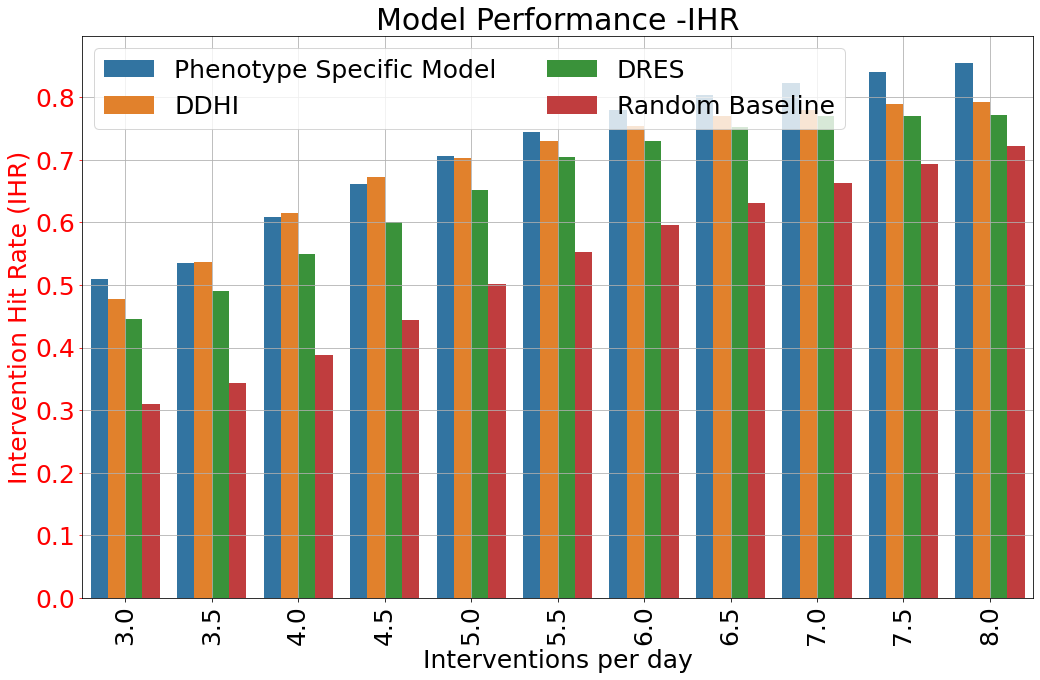

In [44]:
import warnings
warnings.filterwarnings('ignore')
extra_dfs = []
for k in np.arange(n_cluster):
    df_cluster = df[df.Subtype.isin(['Cluster {}'.format(k)])]
    all_encodings = []
    for encoding1 in df_cluster.Encoding1.unique():
        if encoding1!=3:
            all_encodings.append(df_cluster[df_cluster.Encoding1.isin([encoding1])])
    results = []
    for dff in all_encodings:
        results.append(np.mean(dff['IHR'].values))
    results = np.array(results)
    df_this_cluster = all_encodings[results.argmax()]
    df_this_cluster['Subtype'] = ['Overall']*df_this_cluster.shape[0]
    df_this_cluster['Encoding'] = ['Phenotype Specific Model']*df_this_cluster.shape[0]
    df_this_cluster['Encoding1'] = 10
    extra_dfs.append(df_this_cluster)


# extra_df = pd.concat(extra_dfs)
# extra_df = extra_df.groupby(['Subtype','Encoding','Encoding1','Interventions per day'],as_index=False).mean()
# extra_dfs.append(df)

extra_dfs.append(df)
df_final = pd.concat(extra_dfs)





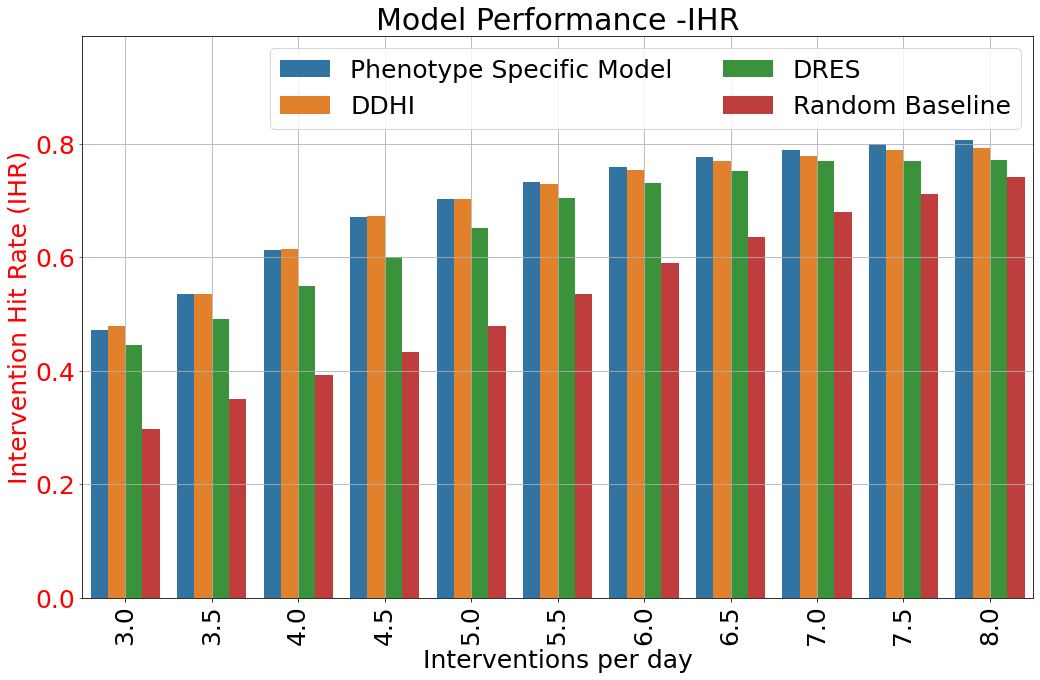

In [114]:

df_final = df1

perf = 'IHR'
# df_final
import seaborn as sns
# df_final = df
# df_final = df_final[df_final['Interventions per day'].isin(np.arange(3,10))]
plt.rcParams.update({'font.size':25})
fig,ax = plt.subplots(1,1,figsize=(15,10),sharey=True)
ax = [ax]
sns.barplot(x='Interventions per day',y=perf,hue='Encoding',data=df_final[df_final.Subtype.isin(['Overall'])],ci=None,ax=ax[0])
plt.legend(ncol=2)
# ax[0].grid()
# ax[0].set_ylabel('Intervention Hit Rate(IHR)',color='r')
# ax[0].legend([],[], frameon=False)
ax[0].tick_params(axis='y', colors='red')
ax[0].tick_params(axis='x', rotation=90)
# ax[0].set_ylim([0,.99])
# ax1=ax.twinx()
# sns.barplot(y='Interventions per day',x='TPI',orient='h',hue='Encoding',data=df_final[df_final.Subtype.isin(['Overall'])],ci=None,ax=ax[1])
if perf=='IHR':
    ax[0].set_ylabel('Intervention Hit Rate (IHR)',color='r')
    ax[0].set_ylim([0,.99])
else:
    ax[0].set_ylabel('Temporal Precision of Interventions (TPI),\n minutes',color='g')
# ax[1].tick_params(axis='y', colors='g')
# plt.xticks(rotation=90)
# # ax[1].grid()
# ax[1].legend(loc=(-1.3,1.01),ncol=2)
# # plt.tight_layout()
# # plt.savefig('./data/images/deep_model.png')
# # plt.tight_layout()
ax[0].grid()

plt.title('Model Performance -'+str(perf))
# ax[1].grid()
plt.tight_layout()
plt.savefig('./data/images/'+str(perf)+'.png')
plt.show()

In [10]:
# df_final.Subtype.unique()
n_clusters = np.unique(list(cluster_dict.values())).shape[0]
n_cluster,n_clusters

(4, 4)

In [80]:
pd.pivot_table(df_final[df_final.Subtype.isin(['Overall'])],values='IHR',columns='Interventions per day',index='Encoding',aggfunc='mean')

Interventions per day,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0
Encoding,,,,,,,,,,,
DDHI,0.478217,0.536173,0.615371,0.672878,0.702959,0.729337,0.753635,0.769118,0.778654,0.788189,0.792680
DRES,0.446028,0.491048,0.548696,0.599806,0.651933,0.703922,0.730457,0.751409,0.768961,0.770218,0.771476
Phenotype Specific Model,0.472840,0.535664,0.612267,0.671762,0.703518,0.732305,0.759088,0.776898,0.788284,0.799670,0.806171
Random Baseline,0.306400,0.352325,0.410243,0.447223,0.492233,0.535642,0.578834,0.623808,0.667089,0.700301,0.733513


In [81]:
df_final[df_final.Subtype.isin(['Overall'])].groupby('Encoding',as_index=False).mean()[['Encoding','IHR','TPI']]

,Encoding,IHR,TPI
0,DDHI,0.692474,38.784342
1,DRES,0.657632,42.324690
2,Phenotype Specific Model,0.696224,38.380122
3,Random Baseline,0.531601,56.412352


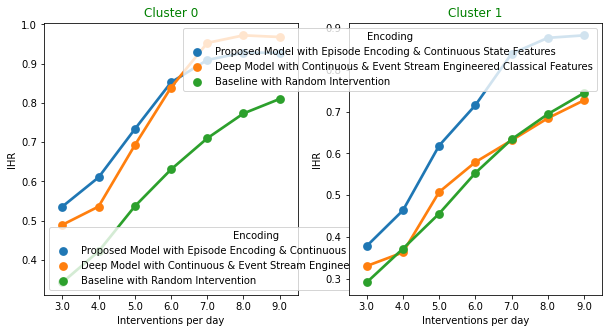

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# df  = pickle.load(open('./data/saved_result/ihr_tpi_dataframe.p','rb'))
df  = df_final
plt.rcParams.update({'font.size':10})
fig,ax = plt.subplots(1,2,figsize=(10,5))
# ax = np.array(ax).reshape((2,2))
sns.barplot(y='Interventions per day',x='IHR',hue='Encoding',data=df[df.Subtype.isin(['Cluster 0'])],ci=None,ax=ax[0])
# ax[0,0].set_ylim([0,1])
# ax[0,0].set_xlabel('')
ax[0].set_title('Cluster 0',color='g')
# ax[0,0].legend([],[])
sns.barplot(y='Interventions per day',x='IHR',hue='Encoding',data=df[df.Subtype.isin(['Cluster 1'])],ci=None,ax=ax[1])
# ax[0,1].set_ylim([0,1])
# ax[0,1].set_xlabel('')
ax[1].set_title('Cluster 1',color='g')
# ax[0,1].legend([],[])
# sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df[df.Subtype.isin(['Cluster 2'])],ci=None,ax=ax[1,0])
# ax[1,0].set_ylim([0,1])
# ax[1,0].set_title('Cluster 2',color='g')
# ax[1,0].legend([],[])
# sns.pointplot(x='Interventions per day',y='IHR',hue='Encoding',data=df[df.Subtype.isin(['Cluster 3'])],ci=None,ax=ax[1,1])
# ax[1,1].set_ylim([0,1])
# ax[1,1].set_title('Cluster 3',color='g')
# ax[1,1].legend(loc=(-1.5,2.3),ncol=2)
# ax[0,0].tick_params(axis='x', rotation=90)
# ax[0,1].tick_params(axis='x', rotation=90)
# ax[1,0].tick_params(axis='x', rotation=90)
# ax[1,1].tick_params(axis='x', rotation=90)

# plt.show()
# plt.figure(figsize=(20,10))
# sns.pointplot(x='Interventions per day',y='TPI',hue='Subtype',data=df[df.Encoding.isin(['Proposed Episode Encoding']) & ~df.Subtype.isin(['Overall'])],ci='sd',ax=ax[1])
# plt.tight_layout()
# plt.savefig('./data/images/cluster_performance.png')
plt.show()

In [ ]:
data_file = './data/episode_encoded_lagged_data/episode_encoded_'+'lagged_{}_windows_standardized_phenotype_with_episode_cluster_check'.format(n_lag)

In [ ]:
plt.hist(puff_data.groupby('Participant').count()["Lapse"].values)
plt.xlabel('Number of Lapses Per Participant')
plt.ylabel("No. of Participants")
plt.show()


puff_data.Participant.unique().shape

In [ ]:
# data = pickle.load(open(data_file,'rb'))
cluster_dict

In [ ]:
data.head()

In [1]:
import tensorflow as tf

In [5]:
a,b,c = tf.unique_with_counts([1,1,1,0])

In [6]:
a

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 0], dtype=int32)>

In [7]:
b

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([0, 0, 0, 1], dtype=int32)>

In [8]:
c

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 1], dtype=int32)>

In [ ]:

# df_subtype = pd.pivot_table(df[df['Interventions per day']<=5],columns='Encoding',index='Subtype',values='IHR',aggfunc='mean').reset_index(level=0)
# phenotype_specific = {}
# for subtype in df_subtype.Subtype.unique():
#     if subtype=='Overall':
#         continue
#     cluster = int(subtype.split(" ")[-1])
#     ddhi = df_subtype[df_subtype.Subtype==subtype]['DDHI'].values[0]
#     dres = df_subtype[df_subtype.Subtype==subtype]['DRES'].values[0]
#     if ddhi>=dres:
#         phenotype_specific[cluster] = [data_dict['DDHI'],'DDHI']
#     else:
#         print('Some')
#         phenotype_specific[cluster] = [data_dict['DRES'],'DRES']
# n_iters = 1
# all_data_v1 = [get_max_results(iteration) for iteration in np.arange(n_iters)]
# all_data = []
# for a in all_data_v1:
#     all_data.extend(a)
# df2 = pd.DataFrame(all_data,columns=['Interventions per day','IHR','TPI','Subtype','Iteration'])
# df2['Encoding'] = ['Phenotype Specific Model']*df2.shape[0]
# df2['Bias'] = bias
# df2['percentile'] = percentile
# df = pd.concat([df2,df])
# df1 = df.copy()

def get_max_results(iteration):
    all_data = []
    final_intpday,final_recall,final_gap = [],[],[]
    result_phenotypes = {}
    for bias in np.arange(.2,.52,.01):
        timescap = 60
        part_days, total_ipd, lapse_captured, total_lapsers,gap_s = 0,0,0,0,[]
        for i,par in enumerate(pars):
            model_name = phenotype_specific[cluster_dict[par]][1]
            # if model_name=='DRES' and bias<.23:
            #     continue
            y_pred, y_test, y_time, y_pid = phenotype_specific[cluster_dict[par]][0]
            a = np.where(y_pid==par)[0]
            lapse_times = get_lapse_times(puff_data,par)
            total_lapsers+=len(lapse_times)
            y_pred_pid = y_pred[a]
            for ii in range(y_pred_pid.shape[1]):
                y_pred_pid[:,ii] = np.array(y_pred_pid[:,ii]>=np.percentile(y_pred_pid[:,ii],percentile),dtype=int)
            y_pred_pid = np.mean(y_pred_pid,axis=1) 
            y_test_pid,y_time_pid = y_test[a],y_time[a]
            y_time_pid = np.array([y+np.timedelta64(time_gap_delta, 'm') for y in y_time_pid])
            y_pred_pid = y_pred_pid[y_time_pid.argsort()]
            y_test_pid = y_test_pid[y_time_pid.argsort()]
            y_time_pid = np.array(sorted(y_time_pid))
            y_day_pid = np.array([str(a)[:10] for a in y_time_pid])
            if smoothing:
                y_pred_pid = smooth_y_pred(y_time_pid,y_pred_pid)
            part_days+=len(np.unique(y_day_pid))
            int_times, ipd =  get_int_times_count(y_time_pid,y_pred_pid,timescap,bias)    
            total_ipd+=ipd
            if len(int_times)>0:
                result_phenotypes, gap_s, lapse_captured = ascertain_lapse(lapse_times, 
                                                                            int_times, 
                                                                            lapse_captured, 
                                                                            cluster_dict, 
                                                                            par, 
                                                                            gap_s, 
                                                                            result_phenotypes,
                                                                            phenotype_specific=False)
            
        final_day_th = float(total_ipd)/part_days
        final_intpday.append(final_day_th)
        final_gap.append(np.median(gap_s))
        final_recall.append(float(lapse_captured)/total_lapsers)
    all_data = get_final_step(final_intpday,final_recall,final_gap,result_phenotypes,iteration,x,all_data,name='Overall',phenotype_specific=False)
    return all_data